<a href="https://colab.research.google.com/github/WinetraubLab/coregister-xy/blob/main/reconstruct_3d.ipynb" target="_parent\"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<a href="https://github.com/WinetraubLab/coregister-xy/blob/main/reconstruct_3d.ipynb" target="_blank">
  <img src="https://img.shields.io/badge/view%20in-GitHub-blue" alt="View in GitHub"/>
</a>

# Overview
Use this notebook to stack together multiple 2D H&E images to 3D stack

In [62]:
#@title Select Reconstruction Mode { run: "auto" }

#@markdown Choose nonlinear (elastic) or affine:
reconstruction_type = "nonlinear" #@param ["nonlinear", "affine"]

# @markdown **Optional:** specify Z range for volume (in mm). Set to None to automatically detect (volume will be saved with z starting from 0). Example: [0, 0.01].
z_range_mm = None  #@param {type:"raw"}

#@markdown Check the box to add OCT view boundary to aligned images:
draw_oct_on_stack = True #@param {type:"boolean"}

# @markdown Coordinate of the center of the OCT view relative to the aligned image above, in mm. Set to "None" if no OCT view. Example: [0.5, 0.5].
oct_square_center_mm = [0.5, 0.5] # @param {type:"raw"}

oct_square_length_mm = 0.5 # Length of one side of the OCT volume

In [63]:
# @title Inputs

# Define output volume
x_range_mm = [0, 1]
y_range_mm = [0, 1]
pixel_size_mm = 1e-3
z_resolution_mm = pixel_size_mm  # By default, set equal to pixel_size_mm for cube voxels

# Define input planes
plane_inputs = []

plane_inputs.append({
"uv_pix": [[1370.0, 282.0], [1368.167, 323.5], [1585.5, 428.833], [1640.167, 427.5], [1348.167, 644.833], [1344.167, 695.5], [1317.5, 411.5], [1266.833, 415.5],  [1307.5, 1274.5], [1303.5, 1315.833], [1523.5, 1423.833], [1579.5, 1425.167], [1279.5, 1618.5], [1275.5, 1673.167], [1199.5, 1399.833], [1160.833, 1399.833], [1250.167, 2279.167], [1244.833, 2327.167], [1467.5, 2391.167], [1526.167, 2392.5], [1223.5, 2647.167], [1219.5, 2700.5], [1147.5, 2367.167], [1202.167, 2367.167], [306.167, 1557.833], [298.167, 1611.167], [295.5, 1664.5], [224.833, 1329.833], [175.5, 1328.5], [330.167, 1257.833], [335.5, 1216.5], [552.833, 1363.167], [604.833, 1365.833], [2341.5, 1366.5], [2336.167, 1414.5], [2622.833, 1475.833], [2562.833, 1474.5], [2316.167, 1738.5], [2320.167, 1686.5], [2288.167, 1454.5]],
"xyz_mm": [[1.413, 0.266, 0.012], [1.412, 0.316, 0.012], [1.637, 0.412, 0.012], [1.686, 0.41, 0.012], [1.412, 0.635, 0.012], [1.41, 0.686, 0.012], [1.367, 0.412, 0.012], [1.316, 0.412, 0.012], [1.41, 1.265, 0.01], [1.41, 1.314, 0.01], [1.633, 1.41, 0.01], [1.684, 1.41, 0.01], [1.41, 1.635, 0.01], [1.41, 1.686, 0.01], [1.314, 1.412, 0.01], [1.264, 1.408, 0.01], [1.412, 2.316, 0.014], [1.41, 2.365, 0.014], [1.635, 2.412, 0.014], [1.682, 2.41, 0.014], [1.41, 2.686, 0.014], [1.41, 2.736, 0.014], [1.316, 2.412, 0.014], [1.365, 2.412, 0.014], [0.412, 1.635, 0.012], [0.41, 1.688, 0.012], [0.412, 1.736, 0.012], [0.316, 1.41, 0.012], [0.262, 1.408, 0.012], [0.412, 1.316, 0.012], [0.408, 1.264, 0.012], [0.635, 1.41, 0.012], [0.684, 1.412, 0.012], [2.414, 1.314, 0.014], [2.408, 1.367, 0.014], [2.688, 1.41, 0.014], [2.629, 1.408, 0.014], [2.412, 1.686, 0.014], [2.41, 1.635, 0.014], [2.367, 1.412, 0.014]],
"image_file_path": "/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2024-07-30 CoregisterXY Examples/r2s1s1.tif"
})
# plane_inputs.append({
# "uv_pix": [[1973.0, 515.0], [1959.833, 546.833], [1942.5, 580.167], [2087.833, 682.833], [2125.167, 697.5], [2167.833, 712.167], [1854.5, 773.5], [1838.5, 808.167], [1898.5, 596.167], [1859.833, 584.167], [1653.833, 1222.167], [1639.167, 1255.5], [1767.167, 1391.5], [1812.5, 1410.167], [1537.833, 1468.833], [1520.5, 1503.5], [1501.833, 1536.833], [1543.167, 1287.5], [1511.167, 1276.833], [896.167, 985.167], [856.167, 969.167], [821.5, 955.833], [849.5, 1157.167], [830.833, 1189.167], [812.167, 1229.167], [1082.833, 1082.5], [1121.5, 1101.167], [953.5, 939.833], [2388.833, 1539.5], [2376.833, 1572.833], [2360.833, 1603.5], [2506.167, 1706.167], [2547.5, 1723.5], [2586.167, 1738.167], [2276.833, 1794.167], [2258.167, 1834.167], [2240.833, 1870.167], [2296.833, 1658.167], [1333.5, 1940.833], [1316.167, 1972.833], [1236.167, 1972.833], [1270.833, 1987.5], [1462.833, 2082.167], [1230.833, 2155.5], [1206.833, 2198.167], [1189.5, 2238.167]],
# "xyz_mm": [[1.413, 0.266, 0.014], [1.41, 0.316, 0.014], [1.41, 0.367, 0.014], [1.635, 0.412, 0.014], [1.684, 0.408, 0.014], [1.735, 0.408, 0.014], [1.41, 0.633, 0.014], [1.412, 0.684, 0.014], [1.365, 0.408, 0.014], [1.312, 0.41, 0.014], [1.41, 1.264, 0.014], [1.412, 1.316, 0.014], [1.633, 1.406, 0.014], [1.684, 1.406, 0.014], [1.41, 1.633, 0.014], [1.41, 1.682, 0.014], [1.412, 1.733, 0.014], [1.311, 1.41, 0.014], [1.264, 1.41, 0.014], [0.367, 1.41, 0.012], [0.314, 1.412, 0.012], [0.264, 1.41, 0.012], [0.412, 1.635, 0.012], [0.412, 1.688, 0.012], [0.41, 1.735, 0.012], [0.637, 1.41, 0.012], [0.684, 1.408, 0.012], [0.412, 1.314, 0.012], [2.412, 1.264, 0.016], [2.412, 1.314, 0.016], [2.412, 1.367, 0.016], [2.633, 1.41, 0.016], [2.684, 1.412, 0.016], [2.733, 1.408, 0.016], [2.408, 1.631, 0.016], [2.408, 1.686, 0.016], [2.408, 1.735, 0.016], [2.367, 1.47, 0.016], [1.412, 2.314, 0.018], [1.412, 2.365, 0.018], [1.316, 2.412, 0.018], [1.365, 2.41, 0.018], [1.635, 2.412, 0.018], [1.414, 2.635, 0.018], [1.41, 2.688, 0.018], [1.41, 2.736, 0.018]],
# "image_file_path": "r2s1s2.tif"
# })
# plane_inputs.append({
# "uv_pix": [[1862.0, 688.0], [1874.833, 646.5], [1885.5, 610.5], [2025.5, 782.5], [2069.5, 794.5], [2114.833, 805.167], [1786.833, 897.167], [1773.5, 937.167], [1758.833, 975.833], [1814.833, 709.167], [1774.833, 699.833], [1738.833, 687.833], [1590.833, 1468.833], [1602.833, 1432.833], [1614.833, 1402.167], [1752.167, 1567.5], [1798.833, 1580.833], [1844.167, 1595.5], [1513.5, 1667.5], [1500.167, 1707.5], [1486.833, 1748.833], [1544.167, 1487.5], [1505.5, 1476.833], [1469.5, 1464.833], [840.5, 1160.833], [853.833, 1128.833], [993.833, 1295.5], [1032.5, 1312.833], [751.167, 1390.167], [737.833, 1430.167], [783.167, 1206.167], [739.167, 1194.167], [701.833, 1182.167], [2407.167, 1747.833], [2419.167, 1714.5], [2429.833, 1681.167], [2572.5, 1845.167], [2620.5, 1859.833], [2664.5, 1871.833], [2335.167, 1962.5], [2319.167, 1999.833], [2300.5, 2042.5], [2340.5, 1811.833], [1321.833, 2234.5], [1335.167, 2199.833], [1483.167, 2335.833], [1525.833, 2350.5], [1572.5, 2362.5], [1241.833, 2437.167], [1225.833, 2479.833], [1209.833, 2522.5], [1276.5, 2254.5], [1235.167, 2242.5]],
# "xyz_mm": [[1.41, 0.361, 0.022], [1.412, 0.314, 0.022], [1.412, 0.264, 0.022], [1.637, 0.408, 0.022], [1.689, 0.412, 0.022], [1.738, 0.41, 0.022], [1.41, 0.633, 0.022], [1.412, 0.684, 0.022], [1.412, 0.735, 0.022], [1.369, 0.41, 0.022], [1.316, 0.412, 0.022], [1.267, 0.412, 0.022], [1.412, 1.365, 0.016], [1.41, 1.312, 0.016], [1.41, 1.264, 0.016], [1.637, 1.41, 0.016], [1.686, 1.412, 0.016], [1.738, 1.412, 0.016], [1.41, 1.635, 0.016], [1.412, 1.686, 0.016], [1.412, 1.736, 0.016], [1.367, 1.412, 0.016], [1.316, 1.412, 0.016], [1.267, 1.412, 0.016], [0.412, 1.316, 0.018], [0.41, 1.265, 0.018], [0.637, 1.41, 0.018], [0.682, 1.412, 0.018], [0.412, 1.635, 0.018], [0.412, 1.686, 0.018], [0.363, 1.41, 0.018], [0.314, 1.408, 0.018], [0.264, 1.408, 0.018], [2.412, 1.365, 0.022], [2.41, 1.312, 0.022], [2.412, 1.265, 0.022], [2.635, 1.41, 0.022], [2.688, 1.41, 0.022], [2.736, 1.41, 0.022], [2.412, 1.635, 0.022], [2.412, 1.686, 0.022], [2.412, 1.736, 0.022], [2.367, 1.47, 0.022], [1.41, 2.365, 0.024], [1.412, 2.316, 0.024], [1.637, 2.41, 0.024], [1.688, 2.41, 0.024], [1.738, 2.412, 0.024], [1.41, 2.635, 0.024], [1.41, 2.686, 0.024], [1.412, 2.736, 0.024], [1.367, 2.412, 0.024], [1.316, 2.414, 0.024]],
# "image_file_path": "r2s1s3.tif"
# })

In [64]:
# @title Environment Setup

from google.colab import drive
drive.mount('/content/drive')

!git clone https://github.com/WinetraubLab/coregister-xy.git
%cd coregister-xy

from plane.fit_plane_elastic import FitPlaneElastic
from plane.fit_plane import FitPlane
import matplotlib.pyplot as plt
import os
from google.colab import files
import math
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import tifffile
from scipy.ndimage import map_coordinates
import plotly.graph_objects as go

%cd ..

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path 'coregister-xy' already exists and is not an empty directory.
/content/coregister-xy
/content


In [65]:
# @title Fit planes

# Fit individual planes
fps = []
xyz_points = []
for plane_input in plane_inputs:
  if reconstruction_type == "nonlinear":
    fp = FitPlaneElastic.from_points(plane_input['uv_pix'],plane_input['xyz_mm'])
  else:
    fp = FitPlane.from_template_centers(plane_input['uv_pix'],plane_input['xyz_mm'])
  fps.append(fp)
  xyz_points.append(np.array(plane_input['xyz_mm']))

In [66]:
# @title Visualize Planes
# @title Plot all best fit planes in 3D

def plot_multiple_planes(planes_points):
    """Plots multiple best-fit planes from given sets of 3D points in an interactive plot."""

    fig = go.Figure()
    colors = ['Blues', 'Oranges', 'Greens', 'Purples', 'Reds']
    colors_points = ['blue', 'brown', 'ForestGreen', 'purple', 'burgundy']

    for idx, points in enumerate(planes_points):
        # Compute best-fit plane
        centroid = np.mean(points, axis=0)
        centered_points = points - centroid
        _, _, vh = np.linalg.svd(centered_points)
        normal = vh[-1]

        # Ensure the normal is pointing upwards (positive Z-component)
        if normal[2] < 0:
            normal = -normal

        A, B, C = normal
        D = -np.dot(normal, centroid)

        # Define grid for plane
        xlim, ylim = np.ptp(points[:, 0]), np.ptp(points[:, 1])
        xx, yy = np.meshgrid(
            np.linspace(np.min(points[:, 0])-0.2*xlim, np.max(points[:, 0])+0.2*xlim, 20),
            np.linspace(np.min(points[:, 1])-0.2*ylim, np.max(points[:, 1])+0.2*ylim, 20)
        )
        zz = (-A * xx - B * yy - D) / C  # Solve for z in Ax + By + Cz + D = 0

        # Plot the plane
        fig.add_trace(go.Surface(
            x=xx, y=yy, z=zz,
            colorscale=colors[idx % len(colors)],  # Cycle through colors
            opacity=0.5,
            showscale=False,
            name=f'Plane {idx+1}'
        ))

        # Plot the points
        fig.add_trace(go.Scatter3d(
            x=points[:, 0],
            y=points[:, 1],
            z=points[:, 2],
            mode='markers',
            marker=dict(size=5, color=colors_points[idx % len(colors_points)], opacity=0.8),
            name=f'Slice {idx+1}'
        ))

    # Set axis labels and improve visibility
    fig.update_layout(
        scene=dict(
            xaxis_title='X (mm)',
            yaxis_title='Y (mm)',
            zaxis_title='Z (mm)',
            aspectmode='auto'
        ),
        title="Multiple Fitted Planes with 3D Points (Interactive)",
    )

    # Show interactive plot
    fig.show()

plot_multiple_planes(xyz_points)

In [67]:
slice_thickness = 5e-3
z_tolerance_mm = slice_thickness / 2
tile_px = 500

# Define volume bounds
x_min, y_min = x_range_mm[0], y_range_mm[0]  # bounding box mins
x_max, y_max = x_range_mm[1], y_range_mm[1]  # bounding box maxs

# Bilinear sampling from image
def bilinear_sample_batch(image, uv_coords):
    h, w, _ = image.shape
    uv_coords = np.array(uv_coords)
    u = uv_coords[:, 0]
    v = uv_coords[:, 1]

    # Clamp to valid indices
    u = np.clip(u, 0, w - 1)
    v = np.clip(v, 0, h - 1)

    coords = np.stack([v, u], axis=0)  # shape (2, N)
    return np.stack([
        map_coordinates(image[..., c], coords, order=3) # Cubic interpolation = preserves more detail
        for c in range(3)
    ], axis=-1).astype(np.uint8)  # shape (N, 3)


if z_range_mm is not None:
    z_min, z_max = z_range_mm[0], z_range_mm[1]
else:
    z_values = [xyz[2] for plane in plane_inputs for xyz in plane["xyz_mm"]]
    z_min = math.floor(min(z_values) / z_resolution_mm) * z_resolution_mm
    z_max = math.ceil(max(z_values) / z_resolution_mm) * z_resolution_mm
print("Z range: ", z_min, z_max)

# Number of voxels per axis
nx = int((x_max - x_min) / pixel_size_mm)
ny = int((y_max - y_min) / pixel_size_mm)
nz = int((z_max - z_min) / z_resolution_mm)

# Coordinate axes
x_vals = x_min + np.arange(nx) * pixel_size_mm
y_vals = y_min + np.arange(ny) * pixel_size_mm
z_vals = z_min + np.arange(nz) * z_resolution_mm

full_voxel_grid = np.zeros((nz, ny, nx, 3), dtype=np.uint8)
full_z_error = np.full((nz, ny, nx), np.inf, dtype=np.float32)

# Process each image
for img_input, fp in zip(plane_inputs, fps):
    image = cv2.imread(img_input["image_file_path"], cv2.IMREAD_COLOR)
    if image is None:
        print(f"Failed to read {img_input['image_file_path']}")
        continue

    print(f"Processing: {img_input['image_file_path']}")
    h, w = image.shape[:2]

    # Loop over tiles in UV/image space
    img_shape = image.shape[:2]
    n_tiles_y = int(np.ceil(img_shape[0] / tile_px))
    n_tiles_x = int(np.ceil(img_shape[1] / tile_px))

    for ty in range(n_tiles_y):
        for tx in range(n_tiles_x):
            print(f"Processing tile ({tx}, {ty})")
            u_start = tx * tile_px
            v_start = ty * tile_px
            u_end = min(u_start + tile_px, img_shape[1])
            v_end = min(v_start + tile_px, img_shape[0])

            # Sample UV grid for this tile
            uu, vv = np.meshgrid(
                np.linspace(u_start, u_end, tile_px, endpoint=False),
                np.linspace(v_start, v_end, tile_px, endpoint=False)
            )
            uv_tile = np.stack([uu.ravel(), vv.ravel()], axis=-1)

            xyz_tile = fp.get_xyz_from_uv(uv_tile)
            x_tile_min, y_tile_min = xyz_tile[:, 0].min(), xyz_tile[:, 1].min()
            x_tile_max, y_tile_max = xyz_tile[:, 0].max(), xyz_tile[:, 1].max()

            # Clip to voxel grid bounds
            i_start = max(0, int((x_tile_min - x_min) / pixel_size_mm))
            i_end   = min(nx, int((x_tile_max - x_min) / pixel_size_mm))
            j_start = max(0, int((y_tile_min - y_min) / pixel_size_mm))
            j_end   = min(ny, int((y_tile_max - y_min) / pixel_size_mm))

            if i_start >= i_end or j_start >= j_end: # out of bounds
                continue

            # Local voxel coords
            local_x = x_vals[i_start:i_end]
            local_y = y_vals[j_start:j_end]
            local_z = z_vals

            zz, yy, xx = np.meshgrid(local_z, local_y, local_x, indexing='ij')
            local_voxels = np.stack([xx.ravel(), yy.ravel(), zz.ravel()], axis=-1)
            voxel_indices = np.arange(local_voxels.shape[0])

            local_rgb = np.zeros((len(local_voxels), 3), dtype=np.uint8)
            local_error = np.full(len(local_voxels), np.inf, dtype=np.float32)

            # Project voxels back to UV for sampling
            uv_coords = fp.get_uv_from_xyz(local_voxels)
            xyz_from_uv = fp.get_xyz_from_uv(uv_coords)
            warped_z = xyz_from_uv[:, 2]
            z_error = np.abs(local_voxels[:, 2] - warped_z)

            u, v = uv_coords[:, 0], uv_coords[:, 1]
            in_bounds = (u >= 0) & (u < w) & (v >= 0) & (v < h)
            valid = (z_error <= z_tolerance_mm) & in_bounds
            better = valid & (z_error < local_error)

            if np.any(better):
                rgb_sampled = bilinear_sample_batch(image, uv_coords[better])
                local_rgb[better] = rgb_sampled
                local_error[better] = z_error[better]

            # Write local data into global volume
            k_idx = voxel_indices // ((j_end - j_start) * (i_end - i_start))
            rem = voxel_indices % ((j_end - j_start) * (i_end - i_start))
            j_idx = rem // (i_end - i_start)
            i_idx = rem % (i_end - i_start)

            abs_k = k_idx
            abs_j = j_idx + j_start
            abs_i = i_idx + i_start

            current_errors = full_z_error[abs_k, abs_j, abs_i]
            update_mask = local_error < current_errors

            full_voxel_grid[abs_k[update_mask], abs_j[update_mask], abs_i[update_mask]] = local_rgb[update_mask]
            full_z_error[abs_k[update_mask], abs_j[update_mask], abs_i[update_mask]] = local_error[update_mask]

# Add blank voxels to save volume with z starting at 0 if origin is not already in the volume
if z_min > 0:
    nz = int((z_min) / z_resolution_mm)
    blank_voxels = np.zeros((nz, ny, nx, 3))

    full_voxel_grid_origin = np.concatenate([blank_voxels, full_voxel_grid], axis=0).astype(np.uint8)
else:
    full_voxel_grid_origin = full_voxel_grid.astype(np.uint8)


Z range:  0.01 0.014
Processing: /content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2024-07-30 CoregisterXY Examples/r2s1s1.tif
Processing tile (0, 0)
Processing tile (1, 0)
Processing tile (2, 0)
Processing tile (3, 0)
Processing tile (4, 0)
Processing tile (5, 0)
Processing tile (6, 0)
Processing tile (7, 0)
Processing tile (0, 1)
Processing tile (1, 1)
Processing tile (2, 1)
Processing tile (3, 1)
Processing tile (4, 1)
Processing tile (5, 1)
Processing tile (6, 1)
Processing tile (7, 1)
Processing tile (0, 2)
Processing tile (1, 2)
Processing tile (2, 2)
Processing tile (3, 2)
Processing tile (4, 2)
Processing tile (5, 2)
Processing tile (6, 2)
Processing tile (7, 2)
Processing tile (0, 3)
Processing tile (1, 3)
Processing tile (2, 3)
Processing tile (3, 3)
Processing tile (4, 3)
Processing tile (5, 3)
Processing tile (6, 3)
Processing tile (7, 3)
Processing tile (0, 4)
Processing tile (1, 4)
Processing tile (2, 4)
Processing tile (3, 4)
Processing tile (4, 4)
Processin

In [68]:
# Save each Z slice in multi page TIFF

tifffile.imwrite(
    f'output_volume.tiff',
    full_voxel_grid_origin,
    bigtiff=True,
    resolution=(10 / pixel_size_mm, 10 / pixel_size_mm),
    resolutionunit='centimeter',
    compression='deflate' # Lossless
)

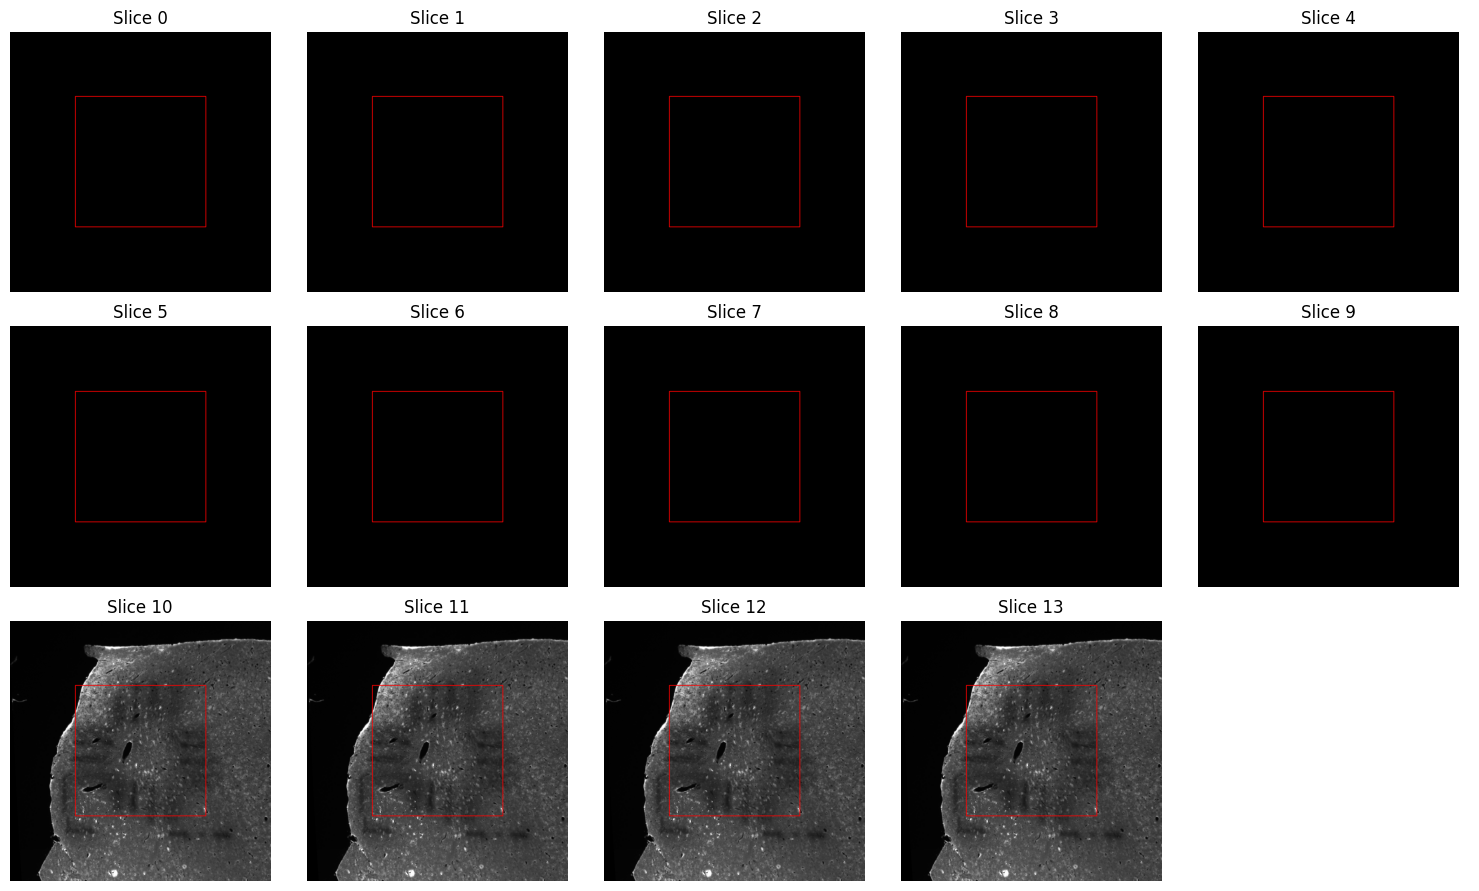

output_volume_with_OCT.tiff is ready to download!


In [69]:
# @title Add OCT View to Stack
if draw_oct_on_stack and oct_square_center_mm is not None:
  oct_xy_mm = [oct_square_center_mm[0] - oct_square_length_mm / 2, oct_square_center_mm[1] - oct_square_length_mm / 2] # Bottom left / min coord

  oct_xy_px = [oct_xy_mm[0] / pixel_size_mm, oct_xy_mm[1] / pixel_size_mm]
  oct_size_px = oct_square_length_mm / pixel_size_mm
  corners = np.array((oct_xy_px, (oct_xy_px[0] + oct_size_px, oct_xy_px[1]), (oct_xy_px[0] + oct_size_px, oct_xy_px[1] + oct_size_px), (oct_xy_px[0], oct_xy_px[1] + oct_size_px)))

  # Draw on each slice
  stack_with_oct = []
  for img in full_voxel_grid_origin:
    layer = img.copy()
    cv2.polylines(layer, np.int32([corners]), isClosed=True, color=(0, 0, 255), thickness=2)
    stack_with_oct.append(layer)

  stack_with_oct = np.array(stack_with_oct).astype(np.uint8)

  # Show all frames with rectangles
  num_slices = len(stack_with_oct)
  cols = 5  # Number of columns in the grid to display
  rows = math.ceil(num_slices / cols)

  fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
  axes = axes.flatten()

  for i in range(num_slices):
      img_rgb = cv2.cvtColor(stack_with_oct[i], cv2.COLOR_BGR2RGB)
      axes[i].imshow(img_rgb)
      axes[i].set_title(f"Slice {i}")
      axes[i].axis("off")

  # Hide any unused subplots
  for j in range(num_slices, len(axes)):
      axes[j].axis("off")

  plt.tight_layout()
  plt.show()

  # Save final multi page TIFF
  tifffile.imwrite(
      "output_volume_with_OCT.tiff",
      stack_with_oct,
      bigtiff=True,
      resolution=(10 / pixel_size_mm, 10 / pixel_size_mm),
      resolutionunit='CENTIMETER',
      compression='deflate'
  )

  print("output_volume_with_OCT.tiff is ready to download!")


In [70]:
# @title Save file to computer
from google.colab import files

# Get file size in bytes
file_size = os.path.getsize('output_volume.tiff')
print(f"output_volume.tiff file size: {file_size / (1024 * 1024):.2f} MB/{file_size / (1024 * 1024 * 1024):.2f} GB")

with tifffile.TiffFile('output_volume.tiff') as tif:
    # Count the number of pages
    num_pages = len(tif.pages)
    print(f"The TIFF file contains {num_pages} pages.")

print('Open the File in ImageJ!')
# files.download("output_volume.tiff")

output_volume.tiff file size: 3.28 MB/0.00 GB
The TIFF file contains 14 pages.
Open the File in ImageJ!
